**Name: Ali Asghar**

**5122740**

**Portfolio2**

**Paricle  FIlter**

**Particle Filter Implementation**

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  # gravity acceleration (m/s^2)

class ParticleFilter:
    def __init__(self, num_particles, initial_state, initial_covariance, transition_cov, observation_cov, dt):
        self.num_particles = num_particles
        self.particles = np.random.multivariate_normal(initial_state, initial_covariance, num_particles)
        self.weights = np.ones(num_particles) / num_particles
        self.transition_cov = transition_cov
        self.observation_cov = observation_cov
        self.dt = dt

    def predict(self):
        noise = np.random.multivariate_normal([0, 0, 0, 0], self.transition_cov, self.num_particles)
        self.particles[:, 0] += self.particles[:, 2] * self.dt + noise[:, 0]
        self.particles[:, 1] += self.particles[:, 3] * self.dt - 0.5 * g * self.dt**2 + noise[:, 1]
        self.particles[:, 2] += noise[:, 2] + np.random.normal(0, 0.1, self.num_particles)
        self.particles[:, 3] -= g * self.dt + noise[:, 3] + np.random.normal(0, 0.1, self.num_particles)

    def update(self, observation):
        if observation is not None:
            predicted_observation = self.particles[:, :2]
            observation_diff = predicted_observation - observation
            observation_cov_inv = np.linalg.inv(self.observation_cov)
            observation_likelihood = np.exp(-0.5 * np.sum((observation_diff @ observation_cov_inv) * observation_diff, axis=1))
            self.weights *= observation_likelihood
            self.weights += 1.e-300  # avoid round-off to zero
            self.weights /= np.sum(self.weights)  # normalize

    def resample(self):
        indices = np.random.choice(range(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate(self):
        mean = np.average(self.particles, weights=self.weights, axis=0)
        return mean

**Ball Trajectory Simulation for Particle Filter**

In [32]:
"""
    Simulate the true trajectory of the ball based on the launch parameters.

    launch_position: Initial position (x, y).
    launch_speed: Initial speed of the ball.
    launch_angle: Launch angle in degrees.
    time_step: Time increment for simulation.
    total_time: Total time of simulation.
    """
def simulate_ball_trajectory(launch_position, launch_speed, launch_angle, time_step, total_time):
    launch_angle_rad = np.radians(launch_angle)
    initial_velocity_x = launch_speed * np.cos(launch_angle_rad)
    initial_velocity_y = launch_speed * np.sin(launch_angle_rad)

    times = np.arange(0, total_time, time_step)
    true_positions = []
    actual_velocities = []

    for t in times:
        x = initial_velocity_x * t
        y = launch_position[1] + initial_velocity_y * t - 0.5 * g * t**2
        true_positions.append((x, y))
        actual_velocities.append((initial_velocity_x, initial_velocity_y - g * t))

    return np.array(true_positions), np.array(actual_velocities), times

**Handle Noisy Observations**

In [33]:
"""
    Simulate noisy measurements based on the true positions with the option to skip measurements.

    true_positions: True positions of the ball.
    observation_noise_cov: Covariance matrix of the observation noise.
    skip_observations: Boolean to indicate if measurements should be skipped.
    skip_ob_start_time: Start time for skipping measurements.
    skip_ob_stop_time: Stop time for skipping measurements.
    times: Array of time points.
    """

def simulate_noisy_observations(true_positions, observation_noise_cov, skip_observations, skip_ob_start_time, skip_ob_stop_time, times):
    noisy_positions = []
    for t, pos in zip(times, true_positions):
        if skip_observations and skip_ob_start_time <= t <= skip_ob_stop_time:
            noisy_positions.append(None)
        else:
            noisy_pos = pos + np.random.multivariate_normal([0, 0], observation_noise_cov)
            noisy_positions.append(noisy_pos)
    return noisy_positions


**Plot and Simualte**

In [34]:
def simulate_and_plot_trajectory(launch_position, launch_speed, launch_angle, time_step, total_time,
                                 observation_noise, skip_observations, skip_ob_start_time, skip_ob_stop_time,
                                 transition_cov_scale, num_particles, initial_covariance_scale, ball_name):
    observation_noise_cov = np.array([[observation_noise, 0], [0, observation_noise]])

    initial_state = [launch_position[0], launch_position[1],
                     launch_speed * np.cos(np.radians(launch_angle)), launch_speed * np.sin(np.radians(launch_angle))]
    initial_covariance = np.eye(4) * initial_covariance_scale
    transition_cov = np.eye(4) * transition_cov_scale
    observation_cov = observation_noise_cov

    true_positions, actual_velocities, times = simulate_ball_trajectory(launch_position, launch_speed, launch_angle, time_step, total_time)
    noisy_observations = simulate_noisy_observations(true_positions, observation_noise_cov, skip_observations, skip_ob_start_time, skip_ob_stop_time, times)

    pf = ParticleFilter(num_particles, initial_state, initial_covariance, transition_cov, observation_cov, time_step)

    estimated_states = []

    for t, obs in enumerate(noisy_observations):
        pf.predict()
        pf.update(obs)
        pf.resample()
        estimated_state = pf.estimate()
        estimated_states.append(estimated_state)
        if obs is not None:
            print(f"Time: {times[t]:.2f} {ball_name}:")
            print(f"  Actual Observation: {obs}")
            print(f"  Estimated State: {estimated_state[:2]}")

    estimated_states = np.array(estimated_states)

    return true_positions, noisy_observations, estimated_states, times

**Experiment with differnet parameters Values**

Time: 0.00 Ball 1:
  Actual Observation: [  3.18864081 103.2016152 ]
  Estimated State: [102.1232585  102.07494775]
Time: 0.10 Ball 1:
  Actual Observation: [ 8.88526018 98.10302574]
  Estimated State: [104.2429756  104.04473429]
Time: 0.20 Ball 1:
  Actual Observation: [  4.67870766 106.57374642]
  Estimated State: [106.37320339 105.90990011]
Time: 0.30 Ball 1:
  Actual Observation: [  7.6480297  106.30343592]
  Estimated State: [108.49319333 107.69280946]
Time: 0.40 Ball 1:
  Actual Observation: [ 10.61257031 104.73968385]
  Estimated State: [110.60859466 109.35516881]
Time: 0.50 Ball 1:
  Actual Observation: [  9.90155997 108.2340743 ]
  Estimated State: [112.73689038 110.93837473]
Time: 0.60 Ball 1:
  Actual Observation: [ 15.03231308 111.81768294]
  Estimated State: [114.8635832  112.41529868]
Time: 0.70 Ball 1:
  Actual Observation: [ 15.80800612 110.58410757]
  Estimated State: [116.98089172 113.79850399]
Time: 0.80 Ball 1:
  Actual Observation: [ 17.88078644 112.86231048]
  Est

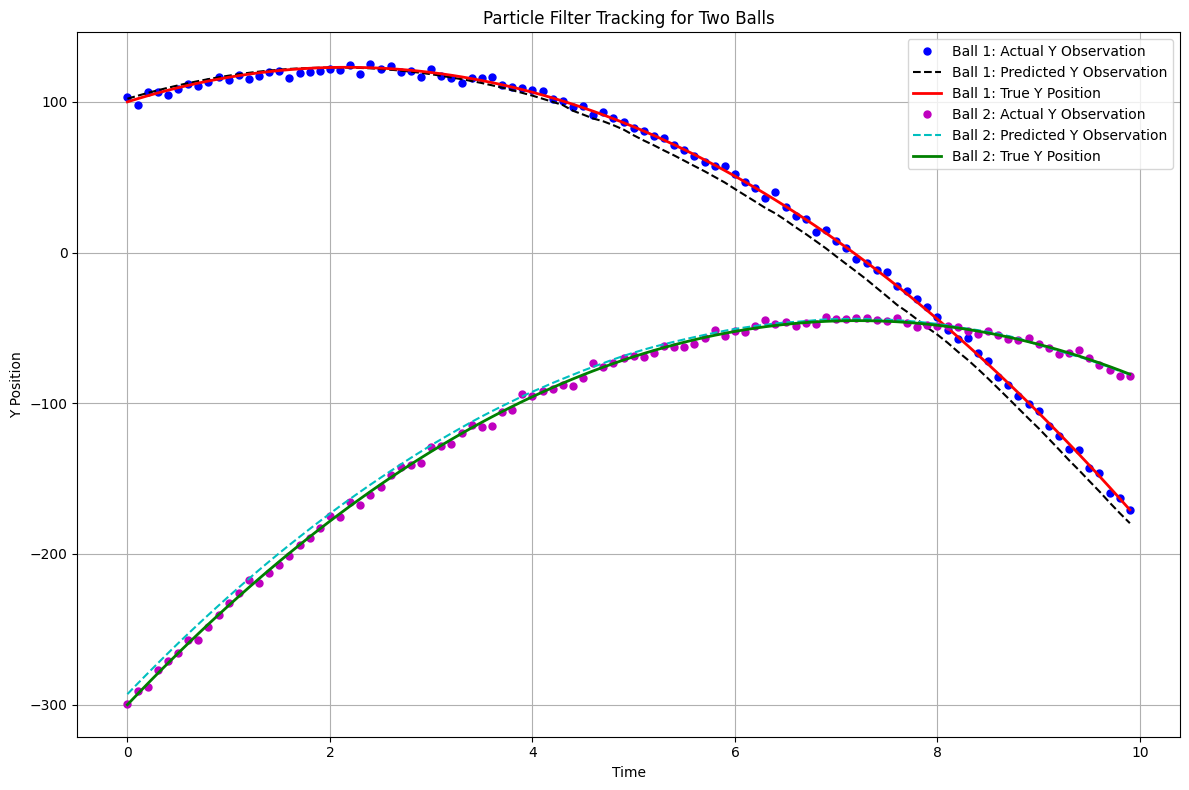

In [35]:
def main():
    launch_position_1 = [100, 100]
    launch_speed_1 = 30
    launch_angle_1 = 45

    launch_position_2 = [-300, -300]
    launch_speed_2 = 100
    launch_angle_2 = 45

    time_step = 0.1
    total_time = 10.0

    observation_noise = 5.0
    skip_observations = False
    skip_ob_start_time = 4
    skip_ob_stop_time = 6

    num_particles = 5000
    initial_covariance_scale = 0.1
    transition_cov_scale = 0.1

    true_positions_1, noisy_observations_1, estimated_states_1, times_1 = simulate_and_plot_trajectory(launch_position_1, launch_speed_1, launch_angle_1, time_step, total_time,
                                                                                                       observation_noise, skip_observations, skip_ob_start_time, skip_ob_stop_time,
                                                                                                       transition_cov_scale, num_particles, initial_covariance_scale, "Ball 1")

    true_positions_2, noisy_observations_2, estimated_states_2, times_2 = simulate_and_plot_trajectory(launch_position_2, launch_speed_2, launch_angle_2, time_step, total_time,
                                                                                                       observation_noise, skip_observations, skip_ob_start_time, skip_ob_stop_time,
                                                                                                       transition_cov_scale, num_particles, initial_covariance_scale, "Ball 2")

    plt.figure(figsize=(12, 8))

    # Plot for Ball 1
    plt.plot(times_1, [obs[1] if obs is not None else np.nan for obs in noisy_observations_1], 'bo', label='Ball 1: Actual Y Observation', markersize=5)
    plt.plot(times_1, estimated_states_1[:, 1], 'k--', label='Ball 1: Predicted Y Observation')
    plt.plot(times_1, true_positions_1[:, 1], 'r', label='Ball 1: True Y Position', linewidth=2)

    # Plot for Ball 2
    plt.plot(times_2, [obs[1] if obs is not None else np.nan for obs in noisy_observations_2], 'mo', label='Ball 2: Actual Y Observation', markersize=5)
    plt.plot(times_2, estimated_states_2[:, 1], 'c--', label='Ball 2: Predicted Y Observation')
    plt.plot(times_2, true_positions_2[:, 1], 'g', label='Ball 2: True Y Position', linewidth=2)

    plt.xlabel('Time')
    plt.ylabel('Y Position')
    plt.title('Particle Filter Tracking for Two Balls')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()